In [126]:
%load_ext autoreload
%autoreload 2
import sys,os
import jax
# add the path to the library and load it
sys.path.insert(0, os.path.abspath("../../"))
from EPlink import Lfit,Compute
from matplotlib import pyplot as plt
import numpy as np
import jax.numpy as jnp
from tqdm import tqdm
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
folder = "Data/"
o_times,samp_times = np.load(folder+"observation_times.npy"),np.load(folder+"simulation_times.npy")
True_traj,Traj_w_locerr,samples,fine_scale_traj = np.load(folder+f"ep_traj_0.npy"),np.load(folder+f"ep_traj_w_err_0.npy"),np.load(folder+f"Post_samps_0.npy"),np.load(folder+f"ep_traj_fine_0.npy")

In [162]:
rc = 100
lam_true,k_true,bias = 80,4,1000
gamma_trans = 0.01
D_trans =0.05
measurement_error2 = 5
kernel_mean = k_true*lam_true
kernel_std = 17.7#jnp.sqrt(k_true*lam_true**2)
upscale_factor = 1000
dt = 17.7/upscale_factor
#round up to the nearest integer
window_size = upscale_factor*50


[Text(0.5, 0, 'Time (min)'), Text(0, 0.5, 'Kernel')]

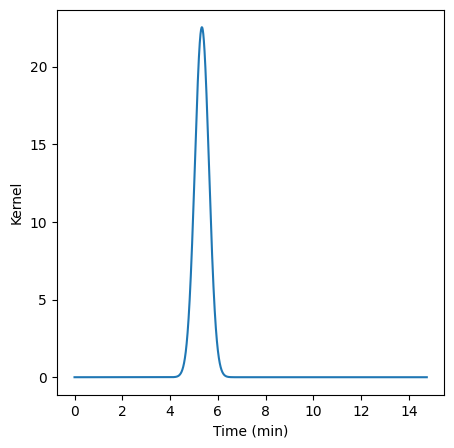

In [164]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ts = np.arange(0,window_size)*dt
ax.plot(ts/60,Lfit.Gamma_gauss(ts,kernel_mean,kernel_std**2,bias))   
ax.set(xlabel="Time (min)",ylabel="Kernel")

In [165]:
filter = Lfit.GaussianProcessTranscription(jnp.array(fine_scale_traj.swapaxes(0,1)),window_size,dt,upscale_factor,gamma_trans,D_trans,measurement_error2,weighting_kernel="Gamma_gauss")
params = jnp.array([rc,kernel_mean,kernel_std**2,bias])
traj = filter.Generate_trajectory(params,verbose=True)
observed_traj = traj+np.random.normal(0,measurement_error2,traj.shape)


100%|██████████| 355/355 [00:00<00:00, 2864.80it/s]


In [166]:
mu_increments, mu_mult_factor, var_mult_factor, var_increment, rate_blocks, T_rate = Lfit.Compute_increments(
            jnp.array([rc,200,kernel_std**2,bias]), filter.trajectory, filter.window_size, filter.dt, filter.upscale_factor, filter.weighting_kernel,filter.gamma_trans,filter.D_trans)

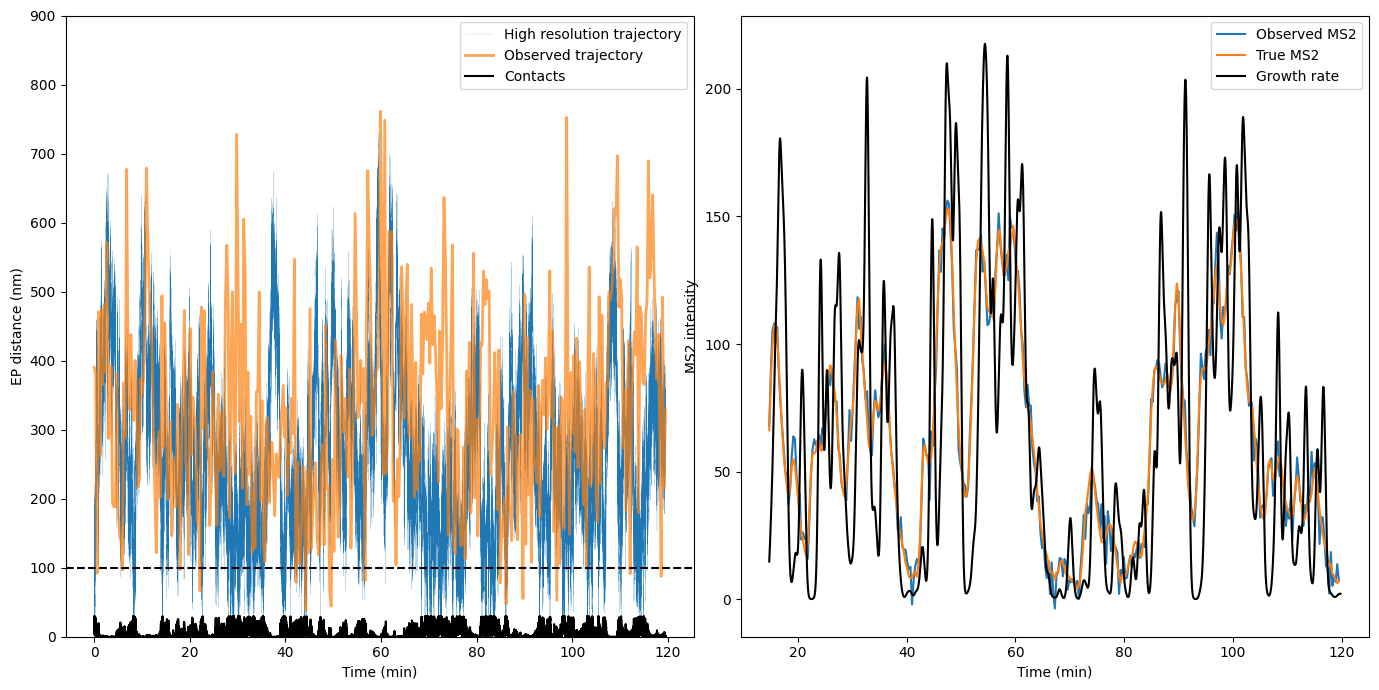

In [167]:
ind_num = np.random.randint(len(samples))
fig,ax = plt.subplots(1,2,figsize=(14,7))
ax[0].plot(samp_times[::-1]/60,np.sqrt(np.sum(fine_scale_traj.T**2,axis=-1))[:len(samp_times)],linewidth=0.1,label="High resolution trajectory")
ax[0].plot(o_times/60,np.sqrt(np.sum(Traj_w_locerr.T**2,axis=-1)),linewidth=2,label="Observed trajectory",alpha=0.7)
ax[0].plot(samp_times[::-1]/60,30*np.exp(-np.sum(fine_scale_traj.T**2,axis=-1)/2/rc**2)[:len(samp_times)],color="k",label="Contacts")
ax[0].set(xlabel="Time (min)",ylabel="EP distance (nm)",ylim=(0,900))
ax[0].axhline(rc,linestyle="--",color="k")
ax[0].legend()
fig.tight_layout()
ax[1].plot(o_times[len(o_times)-len(observed_traj):]/60,observed_traj,label="Observed MS2")
ax[1].plot(o_times[len(o_times)-len(traj):]/60,traj,label="True MS2")
ax[1].plot((window_size+np.arange(0,len(T_rate)))*dt/60,T_rate*100,color="k",label="Growth rate")
ax[1].set(xlabel="Time (min)",ylabel="MS2 intensity")
ax[1].legend()
# fig.savefig("Plots/EP_traj_contacts.png",dpi=300,bbox_inches="tight",facecolor="white")


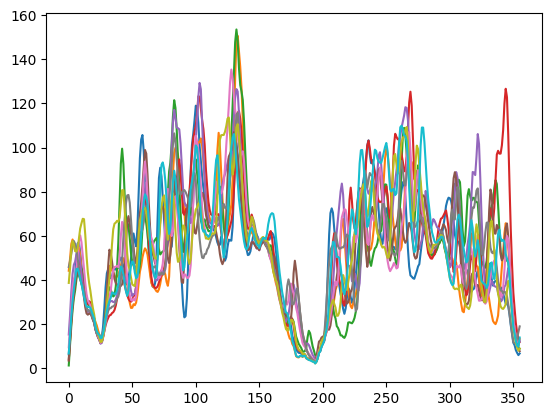

In [168]:
for i in range(10):
    mus,vars = Lfit.GP_predict(params,observed_traj,samples[i],window_size,dt,upscale_factor,"Gamma_gauss",gamma_trans,D_trans,measurement_error2)
    plt.plot(mus)

In [169]:
data = []
folder = "Data/"
for i in range(5):
    o_times,samp_times = np.load(folder+"observation_times.npy"),np.load(folder+"simulation_times.npy")
    True_traj,Traj_w_locerr,samples,fine_scale_traj = np.load(folder+f"ep_traj_{i}.npy"),np.load(folder+f"ep_traj_w_err_{i}.npy"),np.load(folder+f"Post_samps_{i}.npy"),np.load(folder+f"ep_traj_fine_{i}.npy")
    
    filter = Lfit.GaussianProcessTranscription(jnp.array(fine_scale_traj.swapaxes(0,1)),window_size,dt,upscale_factor,gamma_trans,D_trans,measurement_error2,weighting_kernel="Gamma_gauss")
    params = jnp.array([rc,kernel_mean,kernel_std**2,bias])
    traj = filter.Generate_trajectory(params,verbose=True)
    observed_traj = traj+np.random.normal(0,measurement_error2,traj.shape)
    data.append(observed_traj)
    

100%|██████████| 355/355 [00:00<00:00, 2960.66it/s]


100%|██████████| 355/355 [00:00<00:00, 2864.28it/s]


100%|██████████| 355/355 [00:00<00:00, 3278.79it/s]


100%|██████████| 355/355 [00:00<00:00, 3271.25it/s]


100%|██████████| 355/355 [00:00<00:00, 2779.82it/s]


In [170]:
pdict = {"window_size":window_size, "dt":dt,"upscale_factor":upscale_factor,"gamma_trans":gamma_trans,"D_trans":D_trans,"measurement_error":measurement_error2,"weighting_kernel":"Gamma_gauss"}
model = Compute.GP_model(jnp.array(data),"Data",pdict)

In [149]:
kernel_mean

320

In [159]:
kmeans = np.linspace(0,500,20)
llhs = []
for km in tqdm(kmeans):
    params = jnp.array([rc,km,kernel_std**2,bias])
    llhs.append(model.Compute_LLH(params))

100%|██████████| 20/20 [08:47<00:00, 26.37s/it]


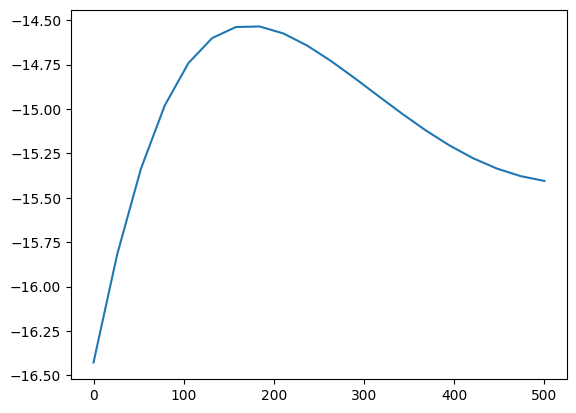

In [160]:
plt.plot(kmeans,-np.array(llhs))

In [143]:
model.Compute_LLH(jnp.array([rc,kernel_mean,kernel_std**2,bias]))

  0%|          | 0/4 [00:00<?, ?it/s]

Array(15.494113, dtype=float32)

In [171]:
model.Fit([50.,kernel_mean*1.1,kernel_std**2/1.1,bias*1.1])

Params: [  54.53602338  351.52198521  284.8755274  1099.99638128] | LLH: 27.334867477416992: : 1it [02:12, 132.42s/it]

Current parameters: [  54.53602338  351.52198521  284.8755274  1099.99638128] | Current log-likelihood: 27.334867477416992


Params: [  65.33296368  350.3753075   285.03480835 1099.98520461] | LLH: 27.08725357055664: : 2it [02:38, 69.76s/it]  

Current parameters: [  65.33296368  350.3753075   285.03480835 1099.98520461] | Current log-likelihood: 27.08725357055664


Params: [  67.37512715  350.14817235  285.06627884 1099.97919268] | LLH: 27.080413818359375: : 3it [03:04, 49.78s/it]

Current parameters: [  67.37512715  350.14817235  285.06627884 1099.97919268] | Current log-likelihood: 27.080413818359375


Params: [  67.48860392  350.12525577  285.0693823  1099.97479185] | LLH: 27.08027458190918: : 4it [03:31, 40.87s/it] 

Current parameters: [  67.48860392  350.12525577  285.0693823  1099.97479185] | Current log-likelihood: 27.08027458190918


Params: [  67.60429694  350.08872297  285.0742789  1099.96510199] | LLH: 27.08001136779785: : 5it [03:58, 35.73s/it]

Current parameters: [  67.60429694  350.08872297  285.0742789  1099.96510199] | Current log-likelihood: 27.08001136779785


Params: [  67.75103844  350.02372804  285.08294372 1099.94544035] | LLH: 27.079511642456055: : 6it [04:24, 32.46s/it]

Current parameters: [  67.75103844  350.02372804  285.08294372 1099.94544035] | Current log-likelihood: 27.079511642456055


Params: [  67.95810695  349.90353621  285.09891553 1099.90644596] | LLH: 27.07855224609375: : 7it [04:50, 30.47s/it] 

Current parameters: [  67.95810695  349.90353621  285.09891553 1099.90644596] | Current log-likelihood: 27.07855224609375


Params: [  68.27450857  349.67306525  285.12947571 1099.82836874] | LLH: 27.076740264892578: : 8it [05:16, 29.07s/it]

Current parameters: [  68.27450857  349.67306525  285.12947571 1099.82836874] | Current log-likelihood: 27.076740264892578


Params: [  68.77498922  349.2278973   285.18841127 1099.67302596] | LLH: 27.073368072509766: : 9it [05:42, 28.13s/it]

Current parameters: [  68.77498922  349.2278973   285.18841127 1099.67302596] | Current log-likelihood: 27.073368072509766


Params: [  69.58676141  348.35993531  285.30317811 1099.36343163] | LLH: 27.0672550201416: : 10it [06:10, 27.95s/it]  

Current parameters: [  69.58676141  348.35993531  285.30317811 1099.36343163] | Current log-likelihood: 27.0672550201416


Params: [  70.91003947  346.66855071  285.5265917  1098.74953864] | LLH: 27.05658531188965: : 11it [06:36, 27.56s/it]

Current parameters: [  70.91003947  346.66855071  285.5265917  1098.74953864] | Current log-likelihood: 27.05658531188965


Params: [  73.01795484  343.4341678   285.95343238 1097.55828586] | LLH: 27.03864097595215: : 12it [07:03, 27.11s/it]

Current parameters: [  73.01795484  343.4341678   285.95343238 1097.55828586] | Current log-likelihood: 27.03864097595215


Params: [  76.19413347  337.54878435  286.72951066 1095.36356301] | LLH: 27.007909774780273: : 13it [07:29, 26.83s/it]

Current parameters: [  76.19413347  337.54878435  286.72951066 1095.36356301] | Current log-likelihood: 27.007909774780273


Params: [ 483.16751561 -537.40218307  402.04092298  766.40908154] | LLH: 15.093286514282227: : 14it [09:14, 50.64s/it]

Current parameters: [ 483.16751561 -537.40218307  402.04092298  766.40908154] | Current log-likelihood: 15.093286514282227


Params: [ 490.82354371 -553.81759495  404.20435127  760.23824834] | LLH: 15.056587219238281: : 15it [10:07, 51.32s/it]

Current parameters: [ 490.82354371 -553.81759495  404.20435127  760.23824834] | Current log-likelihood: 15.056587219238281


Params: [ 503.38692081 -580.73256983  407.7515131   750.12305163] | LLH: 15.021435737609863: : 16it [10:34, 43.83s/it]

Current parameters: [ 503.38692081 -580.73256983  407.7515131   750.12305163] | Current log-likelihood: 15.021435737609863


Params: [ 515.24969409 -606.23773121  411.11264192  740.53974308] | LLH: 15.014904975891113: : 17it [11:00, 38.65s/it]

Current parameters: [ 515.24969409 -606.23773121  411.11264192  740.53974308] | Current log-likelihood: 15.014904975891113


Params: [ 511.92588123 -599.14132625  410.17729108  743.20844267] | LLH: 15.013617515563965: : 18it [11:27, 35.06s/it]

Current parameters: [ 511.92588123 -599.14132625  410.17729108  743.20844267] | Current log-likelihood: 15.013617515563965


Exception ignored in: <function _xla_gc_callback at 0x743e80667560>
Traceback (most recent call last):
  File "/home/hdp/miniconda3/envs/EPlink/lib/python3.12/site-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


In [ ]:
nposteriors = 10
filter_full = Lfit.GaussianProcessTranscription(jnp.array(samples)[:,:nposteriors].swapaxes(0,1).swapaxes(1,-1),window_size,dt,upscale_factor,gamma_trans,D_trans,measurement_error2,weighting_kernel="Gamma_gauss")
mus,vars = filter.Predict(params,jnp.array(observed_traj[0]))

def pred_func(params,input):
    mus,vars = [],[]
    for k in input:
        mu,var = filter.Predict(params,k)
        mus.append(mu[0])
        vars.append(var[0])
    return jnp.array(mus),jnp.array(vars)
# pred_func = lambda params,input: [filter_full.Predict(params,k) for k in tqdm(input)]
# pred_func(params,[observed_traj[0]]*nposteriors)
# LLH_function = lambda params: filter_full.LogLikelihood(pred_func(params,jnp.array([observed_traj[0]]*nposteriors)),jnp.array([observed_traj[0]]*nposteriors))
pred_func = jax.vmap(filter.Predict,(None,0))

LLH_function = lambda params: filter.LogLikelihood(pred_func(params,jnp.array([observed_traj[0]]*nposteriors)),jnp.array([observed_traj[0]]*nposteriors))
rs = np.linspace(10,100,20)
LLH_landscape = []
for r in tqdm(rs):
    LLH_landscape.append(LLH_function(jnp.array([r,kernel_mean,kernel_std**2,bias])))

AttributeError: 'GaussianProcessTranscription' object has no attribute 'Predict'